<a href="https://colab.research.google.com/github/lililibin2022/cs131_notes/blob/master/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


cudnn.benchmark = True
plt.ion()   # interactive mode


# Data augmentation and normalization for training
# Data just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



data_dir = './data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(class_names)



['ants', 'bees']


In [12]:
from google.colab import files
uploaded = files.upload()

Saving data.rar to data.rar


In [ ]:
!pip install unrar
!unrar x data.rar

In [23]:
# License: BSD
# Author: Sasank Chilamkurthy

import requests
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


cudnn.benchmark = True
plt.ion()   # interactive mode


# Data augmentation and normalization for training
# Data just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes



# show a few images
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 70.2MB/s]


Epoch 0/24
----------
train Loss: 0.6026 Acc: 0.6680
val Loss: 0.2148 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5609 Acc: 0.7418
val Loss: 0.2205 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4010 Acc: 0.8156
val Loss: 0.2975 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.3298 Acc: 0.8730
val Loss: 0.3168 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.8897 Acc: 0.7049
val Loss: 0.4366 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.5062 Acc: 0.7869
val Loss: 0.3175 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.5989 Acc: 0.7623
val Loss: 0.3171 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.4051 Acc: 0.8361
val Loss: 0.1906 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3910 Acc: 0.8320
val Loss: 0.2111 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3346 Acc: 0.8484
val Loss: 0.2032 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2327 Acc: 0.8975
val Loss: 0.1845 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.2669 Acc: 0.8893
val Loss: 0.1820 Acc: 0.9477

Ep

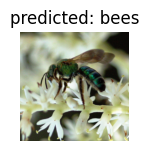

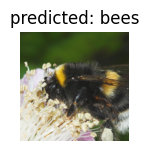

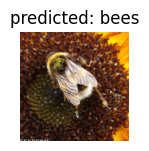

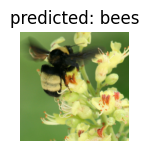

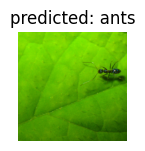

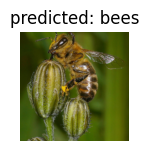

In [24]:
visualize_model(model_ft)

In [25]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [26]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6446 Acc: 0.6721
val Loss: 0.4202 Acc: 0.8039

Epoch 1/24
----------
train Loss: 0.6263 Acc: 0.7049
val Loss: 0.1730 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4947 Acc: 0.7951
val Loss: 0.2506 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.6130 Acc: 0.7541
val Loss: 0.3743 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.4117 Acc: 0.8279
val Loss: 0.1836 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4331 Acc: 0.8115
val Loss: 0.2321 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.5061 Acc: 0.7951
val Loss: 0.1921 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3655 Acc: 0.8566
val Loss: 0.1612 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.3451 Acc: 0.8402
val Loss: 0.1854 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3435 Acc: 0.8361
val Loss: 0.1561 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3194 Acc: 0.8566
val Loss: 0.1647 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3235 Acc: 0.8484
val Loss: 0.1598 Acc: 0.9412

Ep

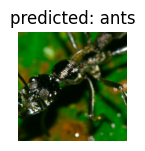

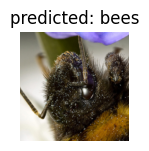

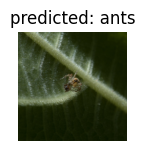

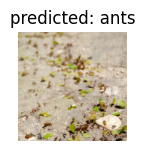

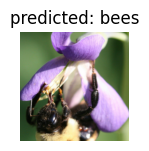

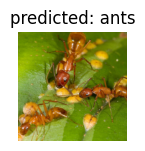

In [27]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [31]:

def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

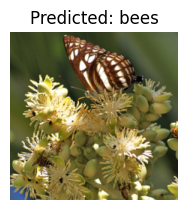

In [32]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()